# Support Vector Machines

# Exercises

## 1.
The idea behind Support Vector Machines is to fit the widest possible "street" that separates two linearly separable classes. The goal is to have the largest possible margin between the decision boundary that separates the two classes.

## 2.
A support vector is any instance of data that is located on border of the "street". The decision boundary of the model is determined by the support vectors.

## 3.
If the features have very different scales, SVMs will tend to neglect small features when fitting the widest possible margin.

## 4.
The distance between a given test instance and the decision boundary can be used to compute a confidence score (being closer to this boundary means a lesser confidence score). To provide the class probabilities, Scikit-Learn uses Logistic Regression on the SVM's scores.

## 5.
The computational complexity of the primal form is of the order of $m$, while the dual form is proportional to a number of at lest $m^2$. Therefore, the primal form will be much faster, and obviously preferred.

## 6.
If the model underfits the training set, there might be too much regularization constraining the model, reducing its degree of freedom so much that it can't learn properly. To decrease the regularization, `gamma` or `C` (or both) would need to be increased.

## 7.
Let $H^\prime, f^\prime, A^\prime$ and $b^\prime$ be the QP parameters for the hard margin problem. The QP parameters for the soft margin problem have $m$ additional parameters, and $m$ additional constraint. They can be defined like so:

- $H$ is equal to $H^\prime$ plus $m$ columns of 0s on the right and $m$ rows of 0s at the bottom
- $f$ is equal to $f^\prime$ with $m$ additional elements, all equal to the value of the hyperparameter $C$
- $b$ is equal to $b^\prime$ with $m$ additional elements, all equal to 0
- $A$ is equal to $A^\prime$ with an extra $m \times m$ identity matrix $I_m$ appended to the right, $-I_m$ just below it, and the rest filled with 0s

## 8.

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import numpy as np

X, y = make_blobs(centers=2, random_state=42)

In [2]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier

lsvc_clf = LinearSVC(loss='hinge', C=5, max_iter=2000).fit(X, y)
svc_clf = SVC(kernel='linear').fit(X, y)
sgd_clf = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001).fit(X, y)

print('LinearSVC:\t', lsvc_clf.coef_, svc_clf.intercept_)
print('SVC:\t\t', svc_clf.coef_, svc_clf.intercept_)
print('SGDClassifier:\t', sgd_clf.coef_, sgd_clf.intercept_)

LinearSVC:	 [[ 0.39210381 -0.08070713]] [0.73415505]
SVC:		 [[ 0.24748994 -0.17407192]] [0.73415505]
SGDClassifier:	 [[ 0.38632511 -0.08241097]] [0.052]


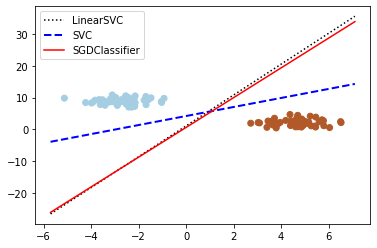

In [3]:
# Compute the slope and bias of each decision boundary
w1 = -lsvc_clf.coef_[0, 0]/lsvc_clf.coef_[0, 1]
b1 = -lsvc_clf.intercept_[0]/lsvc_clf.coef_[0, 1]
w2 = -svc_clf.coef_[0, 0]/svc_clf.coef_[0, 1]
b2 = -svc_clf.intercept_[0]/svc_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)

xlim = plt.xlim()

line1 = np.array([[xlim[0], xlim[0] * w1 + b1], [xlim[1], xlim[1] * w1 + b1]])
line2 = np.array([[xlim[0], xlim[0] * w2 + b2], [xlim[1], xlim[1] * w2 + b2]])
line3 = np.array([[xlim[0], xlim[0] * w3 + b3], [xlim[1], xlim[1] * w3 + b3]])

plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.legend();

`SVC` looks a bit weird but let's call it close enough :)

## 9.

In [4]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

Represent data as `np.uint8` to save some space (without losing any information!):

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np

X, y = X.astype(np.uint8), y.astype(np.uint8)

X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's see how a SVM with RBF kernel performs on the standardized data:

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

clf = SVC().fit(X_train, y_train)
clf.score(X_train, y_train)

0.9866333333333334

Pretty good! How about performance on the test set? Let's see:

In [7]:
clf.score(X_test, y_test)

0.966

## 10.

In [8]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

X, y = fetch_california_housing(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVMs are sensitive to different scales, so we standardize the input data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's start with a linear SVM and see how it does. This will be our baseline:

In [9]:
from sklearn.svm import LinearSVR

svr = LinearSVR(max_iter=5000, random_state=42)
svr.fit(X_train, y_train)

LinearSVR(max_iter=5000, random_state=42)

We will evaluate the model using RMSE, which is a great metric for regression tasks:

In [10]:
from sklearn.metrics import mean_squared_error

y_pred = svr.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

0.979565447829459

Let's try a more complex model now: SVM with RBF kernel. We will perform a Randomized Search to search for promising parameters:

In [11]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

params = {'gamma': reciprocal(0.01, 0.1), 'C': uniform(1, 5)}
rnd_search = RandomizedSearchCV(SVR(), params, cv=3, n_jobs=-1, random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d692b7ac0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f9d68f8e4f0>},
                   random_state=42)

This is the best estimator our randomized search found:

In [12]:
rnd_search.best_estimator_

SVR(C=2.8727005942368127, gamma=0.08927180304353625)

We can see that it performs much better on the training set:

In [13]:
y_pred = rnd_search.best_estimator_.predict(X_train)
np.sqrt(mean_squared_error(y_train, y_pred))

0.5753020309163539

Let's see how it performs on the test set:

In [14]:
y_pred = rnd_search.best_estimator_.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred))

0.5941305370603173